In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval
from sklearn.model_selection import KFold

from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from modules.analysis_funcs import get_idx_to_fold, get_segmented_data, get_test_peaks, aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate
from modules.energy_based import legato_mg

%load_ext autoreload
%autoreload 2

FPS = 100
CONTEXT = 7

# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

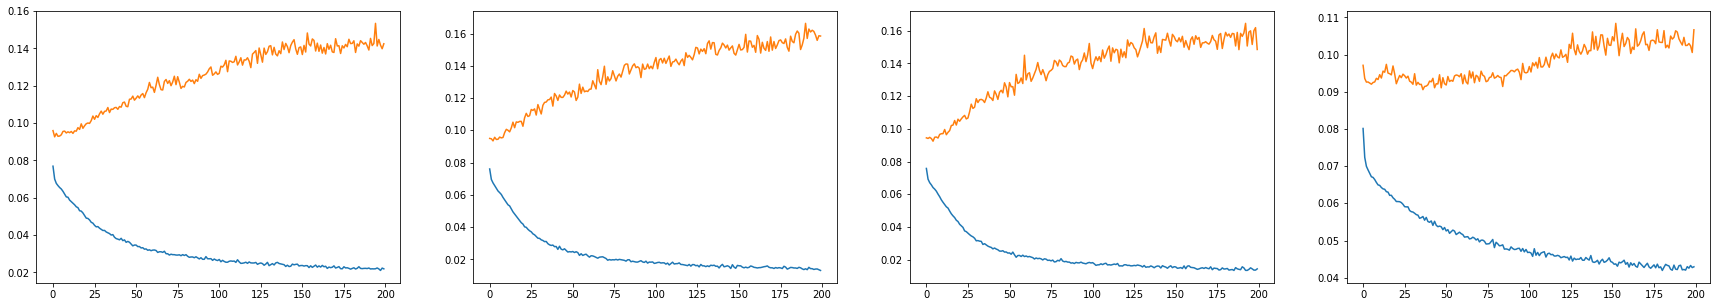

In [19]:
# Show training history
h_paths = [
    "results/cnn-training-221016/fold_0_full-0.001-200eps-standard-finetune-noextend-dropout0.3_history.pickle"
    #"results/cnn-training-221015/fold_0_full-0.001-200eps-nostandard-finetune-noextend-dropout0.3_history.pickle",
    #"results/cnn-training-221015/fold_0_full-0.01-200eps-nostandard-trainable-noextend-dropout0.3_history.pickle",
    #"results/cnn-training-221015/fold_0_full-0.001-200eps-nostandard-trainable-noextend-dropout0.3_history.pickle",
    #"results/cnn-training-221015/fold_0_full-0.001-200eps-nostandard-trainable-noextend-dropout0.5_history.pickle"
]
fig, axs = plt.subplots(1,4, sharex=True, figsize=(30,5))
for ax, h_path in zip(axs, h_paths):
    with open(h_path, "rb") as f:
        history = pickle.load(f)

    ax.plot(history['loss'])
    ax.plot(history['val_loss'])

In [4]:
dss = [
    Dataset("initslurtest"),
    Dataset("slurtest_add_1"),
    Dataset("slurtest_add_2"),
    Dataset("slurtest_test")
]
audio_fnames, label_fnames = [], []
for ds in dss:
    audio_fnames = audio_fnames + ds.get_audio_paths()
    label_fnames = label_fnames + ds.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]

# Dataset info --> at the bottom

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [40]:
# Prepare folds 
# Cross-validation on AB sets
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = list(kf.split(np.arange(36)))
itf = get_idx_to_fold(kf_gen)
print(itf[0])

4


In [6]:
# Remove soon, different for all tests

base_path = "results/cnn-training-220426/"
folds_path = base_path + "folds.pkl"

model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"

folds = kf_gen
#with open(folds_path, "rb") as f:
    #folds = pickle.load(f)

itf = get_idx_to_fold(folds)

neural = False
TOL = 0.025

epochs = np.arange(10,91,10)

test_idx = np.arange(36,40)

NameError: name 'kf_gen' is not defined

In [ ]:
# Tolerance window sensitivity

fss = []
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))
TOLS = np.arange(0.01,0.06,0.01)
for TOL in TOLS:
    fs = []
    rs = []
    ps = []
    CD_list = []
    FN_list = []
    FP_list = []
    for r in test_idx:
        rec_name = os.path.basename(audio_fnames[r])
        x = get_segmented_data(audio_fnames[r])
        out = model.predict(x)
        peaks = get_test_peaks(out, 1./FPS)
        [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
        CD_list.append(CD)
        FN_list.append(FN)
        FP_list.append(FP)
        scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        #print(scores["F-measure"], scores["Recall"], scores["Precision"])
        fs.append(scores["F-measure"])
        ps.append(scores["Precision"])
        rs.append(scores["Recall"])
    print("Mean F: ", np.mean(fs))
    #print("Mean P: ", np.mean(ps))
    #print("Mean R: ", np.mean(rs))
    fss.append(np.mean(fs))

# Saved in "results/computed/cnn_time_prec.npy"

In [8]:
print("Total F: ", np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list))))
print("Total P: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FP_list)))
print("Total R: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FN_list)))

Total F:  0.866033319564918
Total P:  0.8235140089028542
Total R:  0.9131823461091754


In [ ]:
# Grid search

datasets = "a"
test_idx = np.arange(19, len(audio_fnames))
TOL = 0.025
nogen = False
sampling = False
standard = False
n_epochs = 35
av_scores = np.zeros((2,3,3))
tot_scores = np.zeros((2,3,3))
save_path = "results/cnn-training-220425a/"


for i, relu in enumerate([True, False]):
    for j, dropout_p in enumerate([0,0.3,0.5]):
        for k, mode in enumerate(["normal", "finetune", "extend"]):
            if mode=="normal":
                finetune=False
                extend=False
            elif mode=="finetune":
                finetune=True
                extend=False
            elif mode=="extend":
                finetune=True
                extend=True
            
            training_name = "{}-{}-{}eps-{}-{}-{}-dropout{:.1f}{}".format(
                datasets, 
                "nogen" if nogen else ("sample" if sampling else "seq"),
                n_epochs,
                "standard" if standard else "nostandard",
                "finetune" if finetune else "trainable",
                "extend" if extend else "noextend",
                dropout_p,
                "-relu" if relu else ""
            )

            model = tf.keras.models.load_model(save_path + 'fold_{}_{}_model'.format(0, training_name))
            av = []
            CD_list = []
            FN_list = []
            FP_list = []
            for r in test_idx:
                rec_name = os.path.basename(audio_fnames[r])
                x = get_segmented_data(audio_fnames[r])
                out = model.predict(x)
                peaks = get_test_peaks(out, 1./FPS)
                [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
                CD_list.append(CD)
                FN_list.append(FN)
                FP_list.append(FP)
                scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
                av.append(scores["F-measure"])
            av_scores[i,j,k] = np.mean(av)
            tot_scores[i,j,k] = np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list)))
            print(av_scores[i,j,k])
            print(tot_scores[i,j,k])


In [17]:
#Visualization of grid search results

av_scores = np.load("results/computed/av_scores.npy")
tot_scores = np.load("results/computed/tot_scores.npy")

av_scores_table = pd.DataFrame(
    [[av_scores[i//3,i%3,j] for j in range(3)] for i in range(6)],
    columns=["normal", "finetune", "extend"],
    index=[['ReLU', 'ReLU', 'ReLU', 'tanh', 'tanh', 'tanh', ], [0,0.3,0.5,0,0.3,0.5]])

In [38]:
# Fold-wise evaluation

# Selected recordings:
recording_idx = range(len(itf.keys()))      # all
recording_idx = [0]      # single

base_path = "results/cnn-training-220423/"
model_name = "ab-seq-100eps-nostandard"
TOL = 0.025

CD_list = []
FN_list = []
FP_list = []
for r in recording_idx:
    fold = itf[r]
    rec_name = os.path.basename(audio_fnames[r])
    x = get_segmented_data(audio_fnames[r])

    model = tf.keras.models.load_model(base_path + "fold_" + str(fold) + "_" + model_name + "_model")
    out = model.predict(x)
    peaks = get_test_peaks(out, 1./FPS)
    
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
    CD_list.append(CD)
    FN_list.append(FN)
    FP_list.append(FP)

    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    print(rec_name + "\t" + "F-score: {:.2f}".format(100*scores["F-measure"]))



[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
slurtest01.wav	F-score: 92.19


In [30]:
pred_counted = np.array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

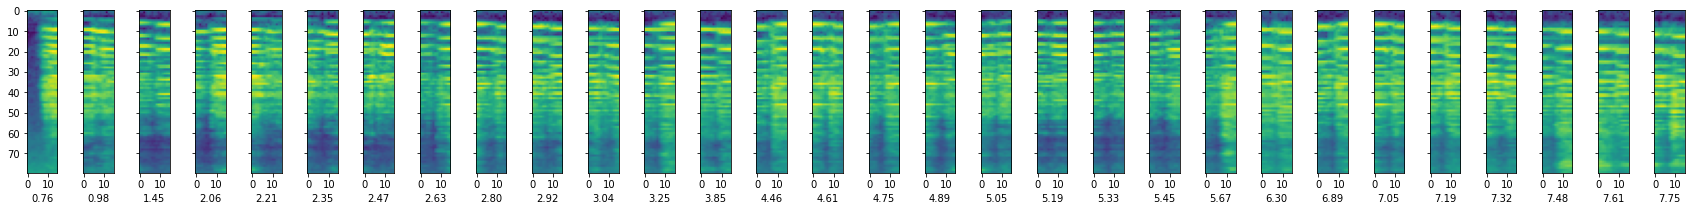

In [39]:

fig, axs = plt.subplots(1,30, figsize=(30,3), sharey=True)
n=0
j=0
while n<30:
    pi = int(peaks[j]*FPS)
    #if pred_counted[j] == 0:
    if True:
        axs[n].imshow(x[pi,:,:,0])
        axs[n].set_xlabel("{:.2f}".format(peaks[j]))
        n+=1
    j+=1
        

In [8]:
# Only first fold
TOL = 0.025
model = tf.keras.models.load_model("results/cnn-training-221014/fold_0_abc-seq-12eps-nostandard-trainable-noextend-dropout0.3_model")

sa_recs = list(np.arange(19)) + [23, 25, 28, 32, 36, 37, 45, 46]
fk_recs = [22, 29, 30, 33, 44, 47]
ir_recs = np.setdiff1d(list(np.arange(49)), sa_recs + fk_recs)
folds = [[np.array(sa_recs), ir_recs]]
av_scores = []
for r in folds[0][1]:
    rec_name = os.path.basename(audio_fnames[r])
    sig = madmom.audio.Signal(audio_fnames[r])
    spect = madmom.audio.spectrogram.Spectrogram(audio_fnames[r])
    hfc = madmom.features.onsets.high_frequency_content(spect)
    onehot, out = aubio_peakpicker_do(hfc, threshold=0.15)
    peaks = aubio_postprocessing(onehot, sig, db_thres=-90, min_ioi_frames=6)/FPS
    
    #x = get_segmented_data(audio_fnames[r])
    #out = model.predict(x)
    #peaks = get_test_peaks(out, 1./FPS)
    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    print(rec_name)
    print(scores["F-measure"]*100)
    print()
    av_scores.append(scores["F-measure"])
print(np.mean(av_scores))

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


stormhatten_IR2.wav
63.128491620111724

slurtest02_IR1.wav
50.74626865671641

slurtest01_IR2.wav
56.92307692307692

slurtest04_IR2.wav
78.48101265822784

slurtest09_IR2.wav
55.952380952380956

janissa_IR2.wav
45.02164502164502

slurtest01_IR1.wav
60.46511627906976

slurtest03_IR1.wav
66.19718309859154

stormhatten_IR1.wav
68.94586894586895

janissa_IR1.wav
57.9185520361991

slurtest02_IR2.wav
57.36434108527132

slurtest03_IR2.wav
65.15151515151516

slurtest04_IR1.wav
77.9874213836478

slurtest05_IR1.wav
58.08823529411765

slurtest05_IR2.wav
37.704918032786885

slurtest09_IR1.wav
50.27932960893855

0.5939720979676035


In [ ]:
# Epoch-wise evaluation

f_at_ep = np.zeros((len(audios), len(epochs)))
CD_list = []
FN_list = []
FP_list = []
for fold, (train_idx, test_idx) in enumerate(folds):
    print("----")
    print("Fold ", fold)
    
    fold_average = []
    for r in test_idx:
        rec_name = os.path.basename(audio_fnames[r])
        sig = madmom.audio.Signal(audio_fnames[r])
        x = get_segmented_data(audio_fnames[r])
        model = tf.keras.models.load_model(base_path + "fold_" + str(fold) + "_" + model_name + "_model")
        for cp_i, epoch in enumerate(epochs):
            model.load_weights(base_path + "fold_" + str(fold) + "_" + model_name + "cp-{:04d}.ckpt".format(epoch))
            out = model.predict(x)
            peaks = get_test_peaks(out, 1./FPS)
            scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
            f_at_ep[r, cp_i] = scores["F-measure"]
        
        #[CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
        #CD_list.append(CD)
        #FN_list.append(FN)
        #FP_list.append(FP)
        #scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        print(rec_name + "\t" + "F-score: {:.2f}".format(100*scores["F-measure"]))
        #fold_average.append(scores["F-measure"])
    #print("Fold {}    average F-score {:.2f}".format(fold, 100*np.mean(fold_average)))
    #print()

In [ ]:
# Dataset info
audio_lengths_sec = [len(audio)/sr for audio,sr in zip(audios, sample_rates)]
iois = [np.ediff1d(onsets) for onsets in onset_schedules]
ioi_spreads = [np.std(np.ediff1d(onsets)) for onsets in onset_schedules]
onset_number = [len(onsets) for onsets in onset_schedules]
mean_ioi = np.sum([np.sum(ioi) for ioi in iois])/np.sum(onset_number)
print(mean_ioi)